In [14]:
from PIL.Image import fromarray
import numpy as np
import seaborn as sns

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

from scipy import ndimage
import data_generation

import operator

In [2]:
from pathlib import Path
legal = data_generation.read_grayscale_pngs(Path('../ai_ml/out/legal/orig'))
illegal = data_generation.read_grayscale_pngs(Path('../ai_ml/out/illegal/orig'))


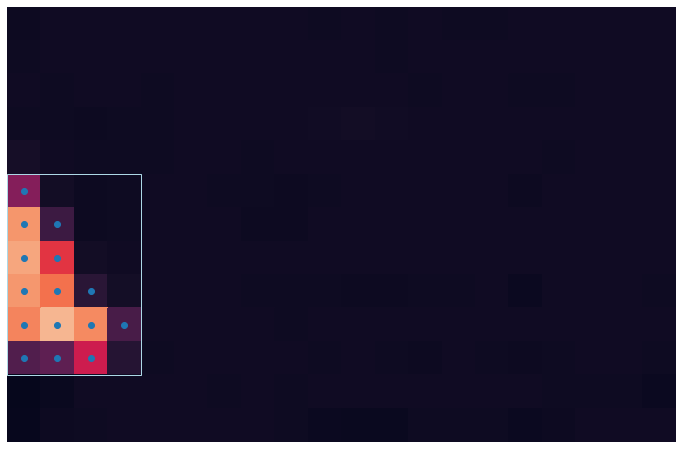

In [3]:
image = illegal[-110]
plt.figure(figsize=(17,8))
ax = sns.heatmap(image, xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255, linewidths=0.0, rasterized=True)

indices = np.fliplr(np.argwhere(image > 25)).T
ax.scatter(indices[0] + 0.5, indices[1] + 0.5)


# Get edges of values above 25 so a "no-go reactangle" can be created.
x_min = np.min(indices[0])
x_max = np.max(indices[0])

y_min = np.min(indices[1])
y_max = np.max(indices[1])

ax.add_patch(Rectangle((x_min, y_min), x_max - x_min + 1, y_max - y_min + 1, facecolor='None', edgecolor='lightblue'))

x_min, x_max, y_min, y_max

height, width = image.shape

range_of_movement = {
    '+x': width - x_max - 2     if x_min > 0 and x_max < width-1    else 0,
    '-x': x_min - 1             if x_min > 0 and x_max < width-1    else 0,
    '+y': height - y_max - 2    if y_min > 0 and y_max < height-1   else 0,
    '-y': y_min - 1             if y_min > 0 and y_max < height-1   else 0,
}

plt.savefig('figures/data_generation_rectangle.pdf')

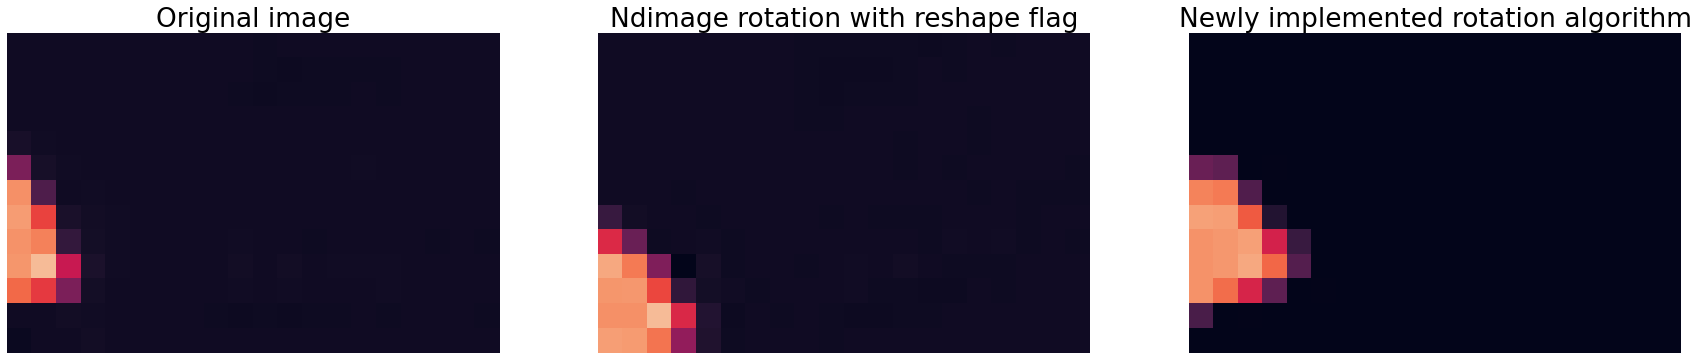

In [4]:

image = illegal[-610]

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})

plt.tight_layout()

angle = 15
plt.subplot(1, 3 ,1)
sns.heatmap(image, square=True, xticklabels=0, yticklabels=0, vmin=0, vmax=255, cbar=False, linewidths=0.0, rasterized=True)
plt.title("Original image")

plt.subplot(1, 3, 2)
sns.heatmap(ndimage.rotate(image, angle, mode='nearest', reshape=False), square=True, xticklabels=0, yticklabels=0, vmin=0, vmax=255, cbar=False, linewidths=0.0, rasterized=True)
plt.title("Ndimage rotation with reshape flag")

plt.subplot(1, 3, 3)
sns.heatmap(data_generation.rotate_image(image, angle), square=True, xticklabels=0, yticklabels=0, vmin=0, vmax=255, cbar=False, linewidths=0.0, rasterized=True)
plt.title("Newly implemented rotation algorithm")

plt.savefig("figures/data_generation_rotation_shift.pdf")

In [16]:
def weighted_average_index(image):
    # Values below 35 are not substantial and they mess with the average so replace them with zero
    image[image < 35] = 0
    total = np.sum(image) 

    if total == 0:
        return None

    val = 0
    for index, xsum in enumerate(np.sum(image, axis=0)):
        val += index * xsum
    xpos = val / total 

    val = 0
    for index, ysum in enumerate(np.sum(image, axis=1)):
        val += index * ysum
    ypos = val / total

    return xpos, ypos

def rotate_image_resize(image, angle, mode='nearest'):
    rotated = ndimage.rotate(image, angle, mode=mode)

    # Shift the image so the center is at the same place
    center_diff = tuple(map(operator.sub, weighted_average_index(image), weighted_average_index(rotated)))
    median_value = np.median(rotated)

    shifted = ndimage.shift(rotated, np.array([center_diff[1], center_diff[0]]), cval=median_value)


    return fromarray(shifted).resize(np.flip(image.shape))


def rotate_image_crop(image, angle, mode='nearest'):
    rotated = ndimage.rotate(image, angle, mode=mode)

    # Shift the image so the center is at the same place
    center_diff = tuple(map(operator.sub, weighted_average_index(image), weighted_average_index(rotated)))
    median_value = np.median(rotated)

    shifted = ndimage.shift(rotated, np.array([center_diff[1], center_diff[0]]), cval=median_value)

    shape_diff = tuple(map(operator.sub, rotated.shape, image.shape))

    # Crop the image since it got bigger by rotation# Crop the image since it got bigger by rotation
    return shifted[ : -shape_diff[0], : -shape_diff[1]]


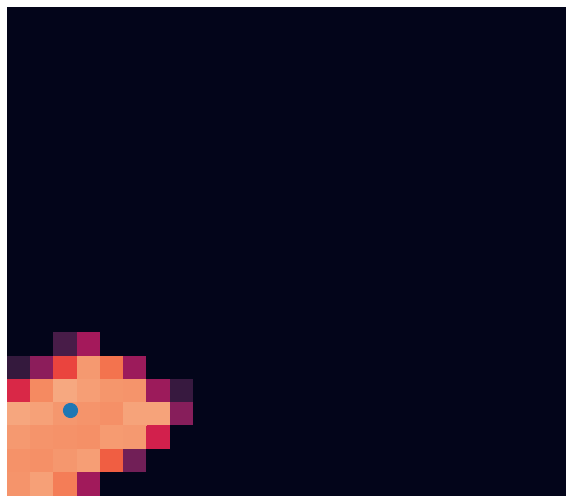

In [6]:
new_image = ndimage.rotate(image, 30, mode='nearest')
new_pos = weighted_average_index(new_image)
plt.figure(figsize=(16,9))
sns.heatmap(new_image, square=True, xticklabels=0, yticklabels=0, vmin=0, vmax=255, cbar=False, linewidths=0.0, rasterized=True)
plt.scatter(new_pos[0], new_pos[1], s=200)
plt.savefig("figures/center_approximation.pdf")

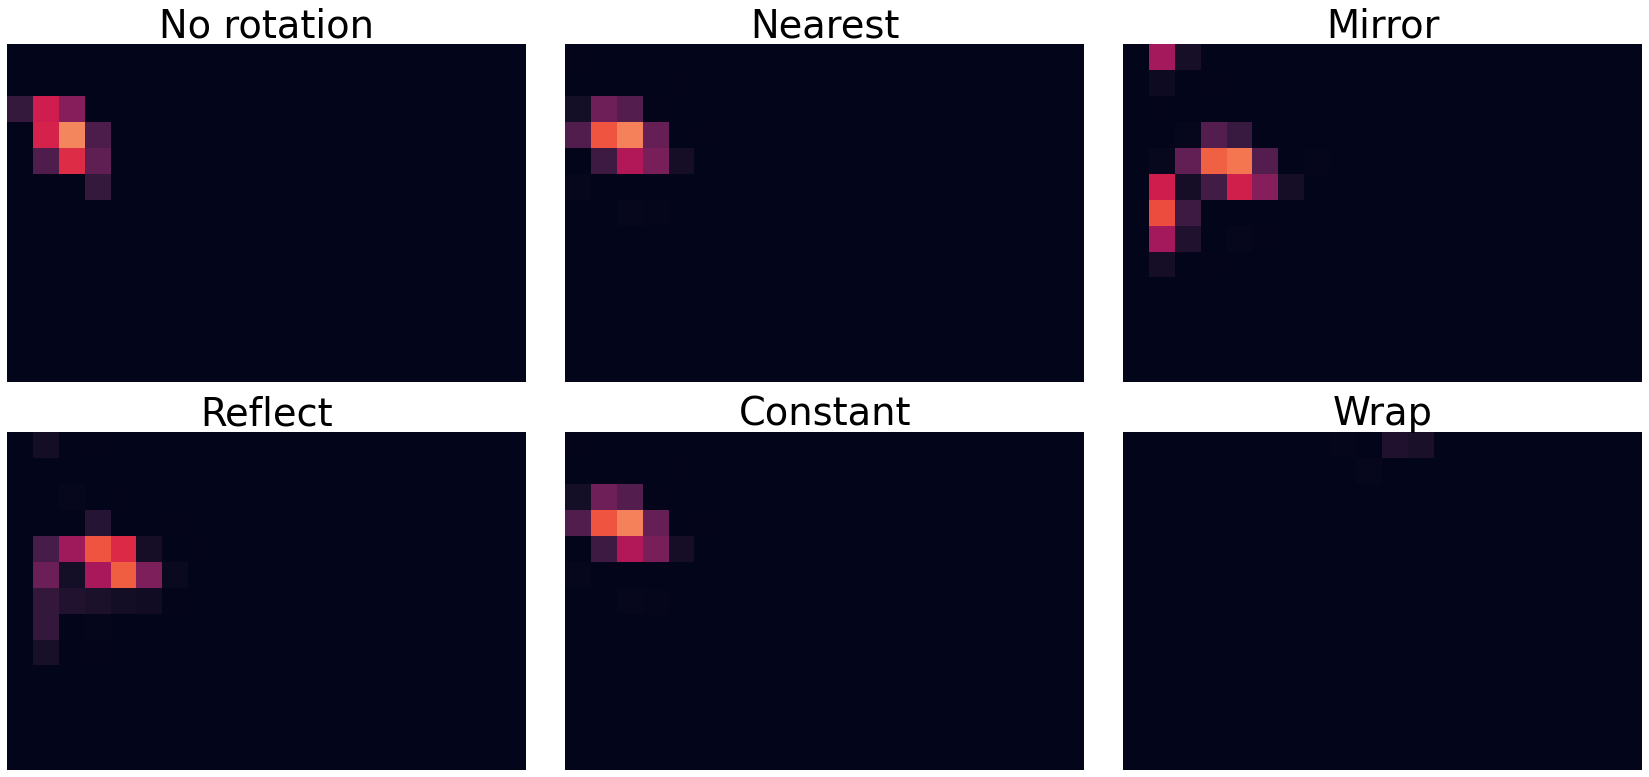

In [18]:
angle = 30

plt.figure(figsize=(30,13))
plt.rcParams.update({'font.size': 32})

for i, mode in enumerate([None, 'Nearest', 'Mirror', 'Reflect', 'Constant', 'Wrap'], start=1):
    plt.subplot(2,3,i)
    if mode is None:
        sns.heatmap(image, xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255, linewidths=0.0, rasterized=True)
        plt.title("No rotation")
    else:
        sns.heatmap(data_generation.rotate_image(image, angle, mode.lower()), xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255, linewidths=0.0, rasterized=True)
        plt.title(mode)

plt.subplots_adjust(hspace=0.15, wspace=0, top=0.90, right=0.9)
plt.savefig("figures/rotation_modes.pdf")



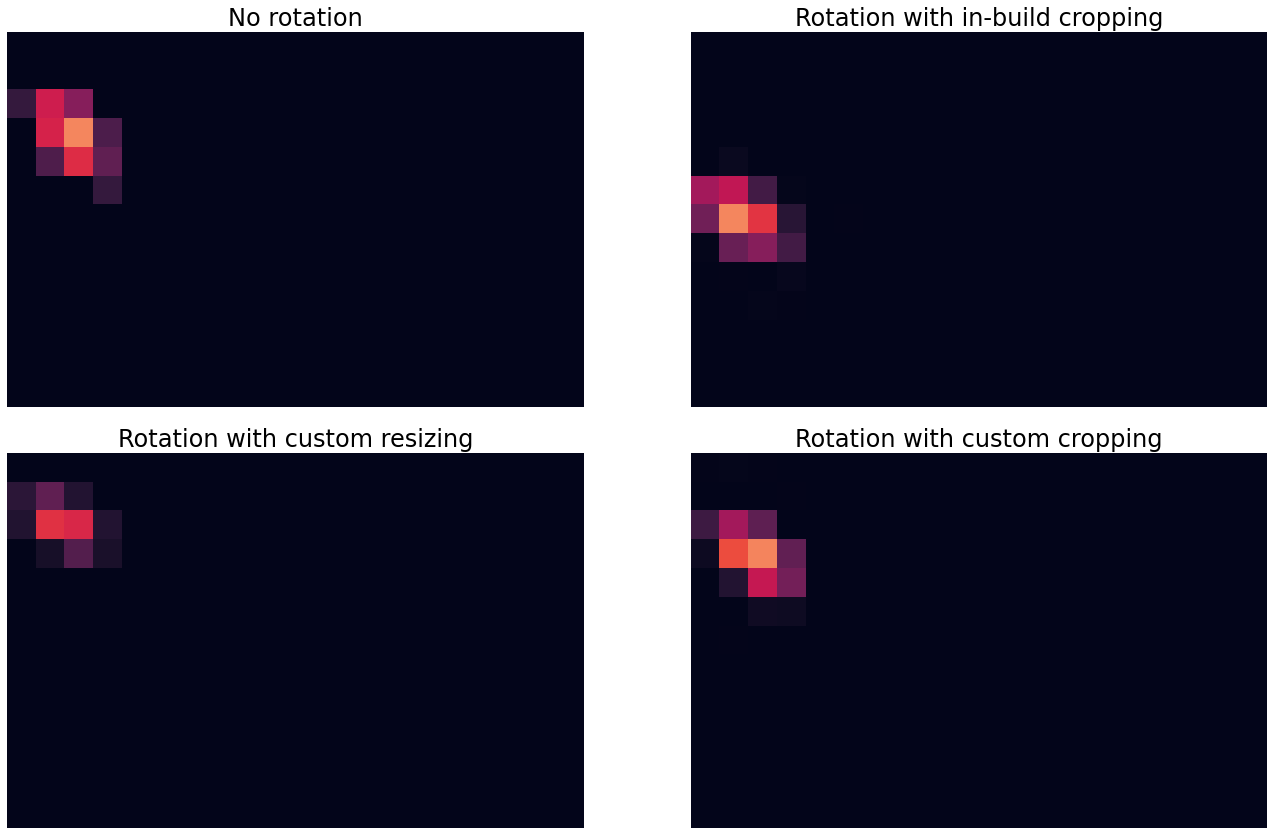

In [19]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,12))

image = illegal[400]

angle = 20
mode = 'nearest'

plt.subplot(2,2,1)
plt.title("No rotation")
sns.heatmap(image, xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255, linewidths=0.0, rasterized=True)

plt.subplot(2,2,2)
plt.title("Rotation with in-build cropping")
sns.heatmap(ndimage.rotate(image, angle, mode=mode, reshape=False), xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255, linewidths=0.0, rasterized=True)

plt.subplot(2,2,3)
plt.title("Rotation with custom resizing")
sns.heatmap(rotate_image_resize(image, angle, mode=mode), xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255, linewidths=0.0, rasterized=True)

plt.subplot(2,2,4)
plt.title("Rotation with custom cropping")
sns.heatmap(rotate_image_crop(image, angle, mode=mode), xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255, linewidths=0.0, rasterized=True)

plt.tight_layout()
plt.savefig('figures/rotation_resize_techniques.pdf')

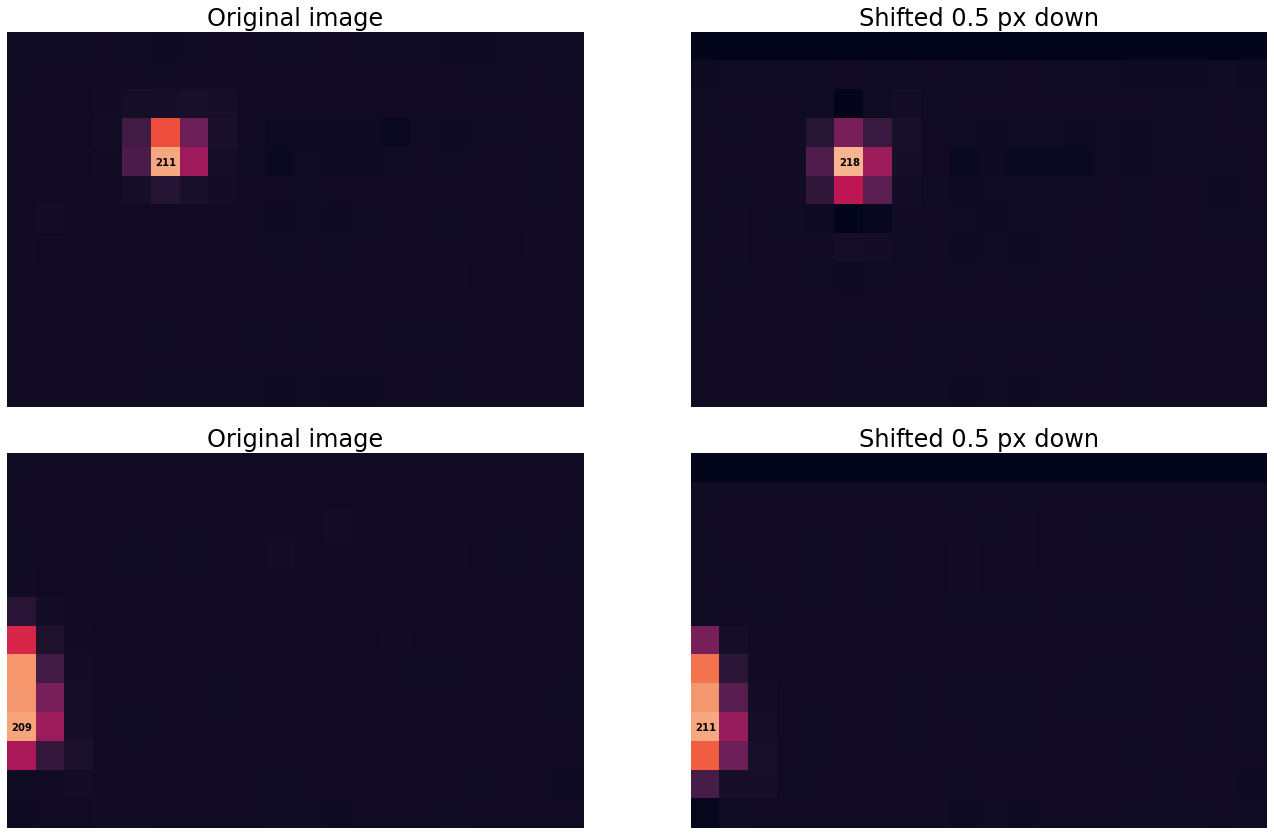

In [20]:
 def show_max(image):
    max_val = np.max(image)
    max_val_indices = np.where(image == max_val)
    plt.text(max_val_indices[1]+0.5, max_val_indices[0]+0.65, str(int(max_val)), color="black", fontweight='bold', fontsize=10, ha="center")

image = legal[1050]

plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 20})


plt.subplot(2,2,1)
plt.title("Original image")
sns.heatmap(image, xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255)
show_max(image)

plt.subplot(2,2,2)
plt.title("Shifted 0.5 px down")
half_shifted = ndimage.shift(image, (0.5,0))
sns.heatmap(half_shifted, xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255)
show_max(half_shifted)

image = illegal[1050]

plt.subplot(2,2,3)
plt.title("Original image")
sns.heatmap(image, xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255)
show_max(image)

plt.subplot(2,2,4)
plt.title("Shifted 0.5 px down")
half_shifted = ndimage.shift(image, (0.5,0))
sns.heatmap(half_shifted, xticklabels=0, yticklabels=0, square=True, cbar=False, vmin=0, vmax=255)
show_max(half_shifted)


plt.tight_layout()
plt.savefig('figures/shifting_half_pixel.pdf')